#Import

In [1]:
!pip install monai

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from pathlib import Path

from sklearn.metrics import classification_report

import monai

from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet264
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)

import numpy as np

In [3]:
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


경로설정

In [4]:
data = '/content/drive/MyDrive/pathology/Data_HW4/image/NOLN_009.png'  
label = '/content/drive/MyDrive/pathology/Data_HW4/filled_label/img_19_mask.png'

pth_dir = '/content/drive/MyDrive/pathology/Data_HW4'

loader 정의

In [5]:
loader = monai.transforms.LoadImage(monai.data.PILReader(converter=lambda image : image.convert("RGBA")))

모델 정의

In [6]:
 torch.cuda.is_available()

True

In [7]:
num_class = 2

## cpu

#if torch.cuda.is_available() == False :
#device = torch.device('cpu') # 저장한 모델을 cpu에서 불러올 때
#model = DenseNet264(spatial_dims=2, in_channels=4, #DenseNet은 CNN 아키텍쳐 중 하나
#                    out_channels=num_class).to(device) # out_channels = 출력 채널 수
## gpu

#else :
device = torch.device("cuda:0") # 저장한 모델을 gpu에서 불러올 때
model = DenseNet264(spatial_dims=2, in_channels=4, #DenseNet은 CNN 아키텍쳐 중 하나
                    out_channels=num_class).to(device) # out_channels = 출력 채널 수


In [8]:
## cpu

#else :
#model.load_state_dict(torch.load(os.path.join(pth_dir, "best_metric_model.pth"),map_location=device))
#model.eval()

## gpu

#if torch.cuda.is_available() == False :
model.load_state_dict(torch.load(os.path.join(pth_dir, "best_metric_model3.pth")))
model.eval()

DenseNet264(
  (features): Sequential(
    (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

## test

In [18]:
img_data, img_meta = loader(data)
label_data, label_meta = loader(label)

img_data.shape, label_data.shape

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (117280283 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


((16619, 7057, 4), (16619, 7057, 4))

In [ ]:
print(type(img_data))

<class 'numpy.ndarray'>


In [ ]:
print(img_data.shape)

(16619, 7057, 4)


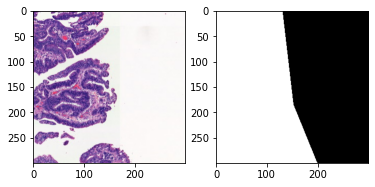

In [ ]:
test_img = img_data[5200:5500, 2700:3000, :] / 255

test_label = label_data[5200:5500, 2700:3000, :] / 255

plt.subplot(1,2,1)
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(test_label)

plt.show()

In [ ]:
print(sum(sum(sum(test_label == 1))))
print(sum(sum(sum(test_label == 1))) >= test_label.size * 0.12)

228780
True


In [ ]:
# 차원의 형태를 (배치, 색깔체널, 가로, 세로)로 만들기 위한 작업

test_img = test_img.reshape((1,) + test_img.shape)

test_img.shape

(1, 300, 300, 4)

In [ ]:
test = torch.tensor(test_img).permute(0,3,1,2).to(device)

test.shape

torch.Size([1, 4, 300, 300])

In [ ]:
y = model(test).argmax(dim=1)

y

tensor([0], device='cuda:0')

In [ ]:
pat = 'D:/python_study/new_patch/normal/img01/Image01001_normal.png'

ary, me = loader(pat)

ary.shape

FileNotFoundError: [Errno 2] No such file or directory: 'D:/python_study/new_patch/normal/img01/Image01001_normal.png'

# Crop slide (RAM 용량 초과)

In [21]:
img_data.shape

(16619, 7057, 4)

In [25]:
#img_rgb = img[5540:11079,2352:4705,:] / 255
#label_rgb = label[5540:11079,2352:4705,:] / 255

#crop_img = img[5540:11079,2352:4705,:]
#crop_label = label[5540:11079,2352:4705,:]

#crop_img = img[3000:12000,1000:6000,:]
#crop_label = label[3000:12000,1000:6000,:]

crop_img = img_data[5000:13500,1000:6000,:] / 255
crop_label = label_data[5000:13500,1000:6000,:] / 255

In [23]:
print(type(crop_img))

<class 'numpy.ndarray'>


In [26]:
print(crop_img.shape)

(8500, 5000, 4)


In [27]:
plt.imsave(f'{pth_dir}/crop_image.png', crop_img)
plt.imsave(f'{pth_dir}/crop_label.png', crop_label)

# inference

In [9]:
# RAM 문제 때문에 이미지를 잘라서 사용해야할 때만
crop_img = '/content/drive/MyDrive/pathology/Data_HW4/crop_image.png'   # crop하지 않을 시 변수 "data"를 사용(처음 부분에 경로 설정에서 주석 풀고 사용)
crop_label = '/content/drive/MyDrive/pathology/Data_HW4/crop_label.png' # crop하지 않을 시 변수 "label"를 사용(처음 부분에 경로 설정에서 주석 풀고 사용)

In [10]:
img, met = loader(crop_img)  # crop하지 않을 시 crop_img 대신 변수 "data"를 사용

label, l_mt = loader(crop_label) # crop하지 않을 시 crop_label 대신 변수 "label"를 사용

In [30]:
print(img.shape)
print(label.shape)

(8500, 5000, 4)
(8500, 5000, 4)


In [11]:
height = img.shape[0]
width = img.shape[1]

In [ ]:
# 히트맵용 검은색 이미지 생성

# hit_map = np.zeros((height, width, 4))
# hit_map[:,:,:] = [0,0,0,1]

In [ ]:
# 생성한 이미지 확인

# hit_map.shape

# plt.imshow(hit_map)

In [12]:
# softmax 함수

def softmax(a) :
    y = []
    c,n = a
    exp_c = np.exp(c)
    exp_n = np.exp(n)
    sum_exp_a = exp_c + exp_n
    C = exp_c / sum_exp_a
    N = exp_n / sum_exp_a

    y.append(C)
    y.append(N)

    y = np.array(y)

    return y


In [13]:
y_p_c = [] #cancer에 대한 예측값을 저장할 list 생성

In [14]:
# inference

h = 60
w = 20

patch_h = height//h #patch의 세로 길이를 저장하는 변수
patch_w = width//w  #patch 의 가로 길이를 저장하는 변수




# for k in range(h*w):
    
for j in range(h):    
    for i in range(w):

        patch = img[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] / 255

        patch = torch.tensor(patch.reshape((1,) + patch.shape)).permute(0, 3, 1, 2).to(device)

        # test_img = test_img.reshape((1,) + test_img.shape)
        # test = torch.tensor(test_img).permute(0,3,1,2).to(device)
        
        y_p = model(patch)[0].cpu().detach().numpy() # 다른 값들은 제외하고 두 class에 대한 각각의 예측값만 출력할 수 있도록 해줌
        y_p = softmax(y_p) # 예측값에 대해 softmax 적용
        #print(y_p)
        y_p_c.append(y_p[0])

        
        #print(type(y_p))
        #y_p
        #soft_pred = softmax(y_p)
        #print(soft_pred)
        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#[0.75737935 0.24262065]
print(0.75737935 + 0.24262065)

# [5.314e-14 1.000e+00]
# [5.314e-14 1.000e+00]
# [1.0026089e-13 1.0000000e+00]
# [3.1321829e-07 9.9999964e-01]

# e는 e앞에 있는 숫자가 소수점 몇 번째 값인지 나타내줌
# 5.314e-14는 소수점 아래 14번째 값이고 그 값은 5.314다

# e-14 = 0.00000000000001

In [ ]:
print(y_p_c) #모델에 입력된 각각의 input이 cancer일 확률들을 모두 리스트(y_p_c)에 저장

[0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.00034203517, 0.0003420

In [ ]:
print(len(y_p_c))

1200


In [15]:
# heatmap 생성방식1 (cancer에 대한 예측값을 투명도로 사용)
# 방식2 사용할시 해당 셀은 실행하지 말 것


k = 0

for j in range(h):    
    for i in range(w):
      hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)),:] = [255,0,0,y_p_c[k]]
      k = k + 1


#hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] = [255,0,0,y_p[0]]

NameError: ignored

In [16]:
# heatmap 생성방식2 (matplotlib를 이용하여 각각의 cancer에 대한 예측값에 대해 매핑되는 색을 할당하는 방식)


## heatmap ploting 함수

def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

In [17]:
heatmap = np.zeros((height, width))

In [18]:
k = 0

for j in range(h):    
    for i in range(w):

        heatmap[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1))] = y_p_c[k]
        k = k + 1

In [32]:
heatmap_binary = heatmap # Dice coefficient

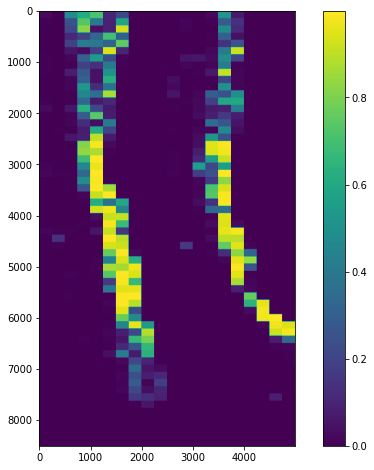

In [19]:
heatmap2d(heatmap)

#기타

In [ ]:
# *******************************************************************

In [ ]:
#patch size 크기와 같은 nd array를 만들고
# 그 array안에 있는 모든 원소의 값을 각 patch에 맞는 predict값으로 채워줌

#color_patch = np.full((60,20),y_p_c[0]) 

In [40]:
color_patch = []  #predict값들로 이루어진 패치(ndarray형태)들을 저장할 리스트 선언

predict_num = len(y_p_c) #패치 총 몇 개인지 확인
print(predict_num)  

1200


In [41]:
# slide 이미지 size : 9000 x 5000
# patch size : 150 x 250

# (9000 x 5000) // (150 x 250) = 1200, 따라서 1200 개의 패치가 생성됨


#patch size 크기와 같은 nd array를 만들고
# 그 array안에 있는 모든 원소의 값을 각 patch에 맞는 predict값으로 채워줌

predict_num = len(y_p_c)

for i in range(predict_num):
  color_patch.append(np.full((patch_h,patch_w),y_p_c[i])) 


In [ ]:
print(type(y_p_c[0]))

<class 'numpy.float32'>


In [ ]:
#print(color_patch)

In [42]:
print(patch_h)
print(patch_w)

141
250


In [43]:
print(type(color_patch))

<class 'list'>


In [ ]:
print(len(color_patch))

1200


In [ ]:
#color_patch = np.array(color_patch) # patch(ndarray형태)들을 담아두었던 list자체를 ndarray형태로 변환

In [ ]:
#print(color_patch.shape)

In [ ]:
whole_color_patch = np.zeros((h,w)) 

In [ ]:
#print(whole_color_patch[60,19])

In [ ]:
# whole_color_patch[0,0] = color_patch[0]

In [ ]:
z = []
for i in range(3):
  z.append(np.full((2,2),i))

print(z)

[array([[0, 0],
       [0, 0]]), array([[1, 1],
       [1, 1]]), array([[2, 2],
       [2, 2]])]


In [ ]:
g = np.zeros((4,4))
g[0:2,0:2] = y_p_c[0]
print(g)

[[0.00034204 0.00034204 0.         0.        ]
 [0.00034204 0.00034204 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [ ]:
# *******************************************************************

# 결과 시각화

In [ ]:
# 이미지 불러오기

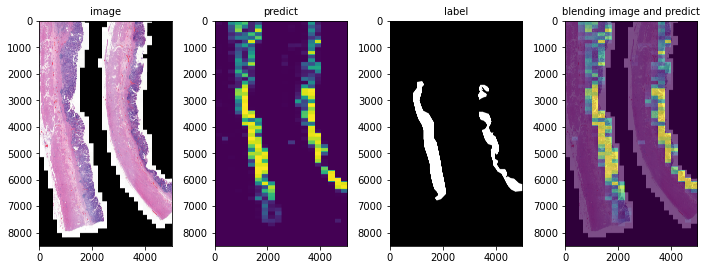

In [20]:
# 이미지 표시


plt.subplot(1,4,1)
plt.imshow(img/255)
plt.title('image', fontsize=10)
plt.subplot(1,4,2)
plt.imshow(heatmap) # 모델의 성능과 패치의 크기에 따라 정확도가 달라짐
plt.title('predict', fontsize=10)
plt.subplot(1,4,3)
plt.imshow(label/255)
plt.title('label', fontsize=10)
plt.subplot(1,4,4)
plt.imshow(img/255)
plt.imshow(heatmap,alpha=0.7)
plt.title('blending image and predict', fontsize=10)
plt.tight_layout()


plt.show()

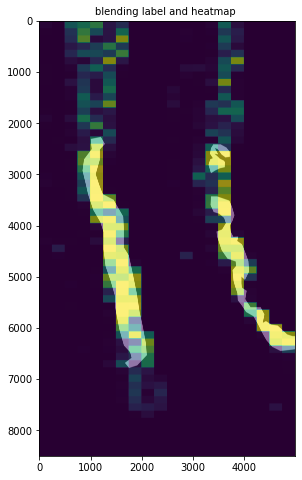

In [21]:
# label과 heatmap을 겹쳐서 보여주기

plt.subplot(1,1,1)
plt.imshow(label/255)
plt.imshow(heatmap,alpha=0.6)
plt.title('blending label and heatmap ', fontsize=10)


plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


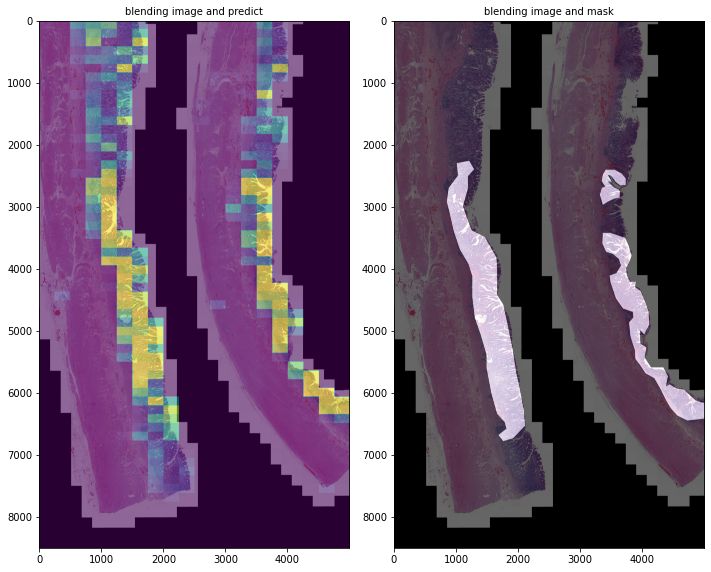

In [22]:
# 슬라이드와 heatmap을 겹친것과 슬라이드와 mask를 겹친 것 비교

plt.subplot(1,2,1)
plt.imshow(img/255)
plt.imshow(heatmap,alpha=0.6)
plt.title('blending image and predict', fontsize=10)
plt.subplot(1,2,2)
plt.imshow(img/255)
plt.imshow(label,alpha=0.6)
plt.title('blending image and mask', fontsize=10)

plt.tight_layout()
plt.show()

# 기타

In [23]:
loss_function = torch.nn.CrossEntropyLoss()

la = torch.tensor([1]).to(device)

loss = loss_function(y_p, la)

print(loss)

TypeError: ignored

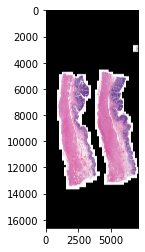

In [ ]:
plt.imshow(img/255)

In [ ]:
list1 = [1,2,3,4]

list1 = np.array(list1)

print(list1)

a, b, c ,d = list1

print(c)

[1 2 3 4]
3


#Dice coefficient

<function matplotlib.pyplot.show>

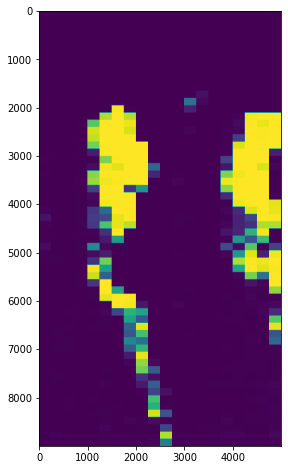

In [36]:
plt.imshow(heatmap_binary/255,cmap=None)
plt.show